In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, LeakyReLU, ReLU, LayerNormalization, GaussianNoise
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D
from keras import initializers
from math import ceil
import time
from tensorflow_addons.layers import SpectralNormalization

In [2]:
#Updated Versions
#Spectral Normalization Model
def build_cifar10_discriminator(image_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #16 output filters, so number of channels jumps from 1 to 16
    #kernel_size = 5 means we use a 5x5 convolution window
    #strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
    model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=(32, 32, 3), 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))) #40
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(32, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    
    #Second layer
    model.add(SpectralNormalization(Conv2D(64, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(128, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))

    #Flatten for Final Output Layer
    model.add(Flatten())

    #Output layer
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Activation("sigmoid"))
    
    #Final Output
    print("\nDiscriminator")
    model.summary()
    return model




#Spectral Normalization Model
def build_cifar10_generator(z_dim=100):
    
    model = Sequential()
    
    #First Layer (4x4)
    model.add(Dense(4*4*128, input_dim=z_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 8x8
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
          use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # output layer
    model.add(Activation('tanh'))

    print("\nGenerator")
    model.summary()
    return model




#Build and Compile Networks
#Variables
#Loss Functions:  Don't seem to matter for performance, any choice will work
#Learning rates:  Trying higher learning rate for Discriminator;  
#Discriminator is easier to succeed, gives generator a better chance at competition, prevents mode collapse
lr_d=2e-4
lr_g=1e-4
z_dim=100
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_shape = X_train[0].shape

D = build_cifar10_discriminator(image_shape)
G = build_cifar10_generator(z_dim)

D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
D.trainable = False

z = Input(shape=(z_dim, ))
D_of_G = Model(inputs=z, outputs=D(G(z)))
D_of_G.compile(Adam(learning_rate=lr_g, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])


Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 spectral_normalization (Spe  (None, 8, 8, 32)         12864     
 ctralNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 spectral_normalization_1 (S  (None, 4, 4, 64)         51328     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4,

In [3]:
#Function for plotting images
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    #images = (1/(2*2.25)) * images + 0.5
    images = 0.5 * images + 0.5
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    
#Function for Plotting Losses During Training
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    #plt.close()
    
#Functions for smoothing labels of 1 and 0
# Smoothing class=1 to [0.8, 1.0]
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)

# Smoothing class=0 to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

#Function for generating latent points to feed into generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
     x_input = np.random.randn(latent_dim * n_samples)
     # reshape into a batch of inputs for the network
     x_input = x_input.reshape((n_samples, latent_dim))
     return x_input
    

#Function for adding noise to images
#  Adding noise to images prevents discriminator overfitting, inhibits performance to allow
#   for better rivalry with the generator (which is generally slower to train)
#This function adds 'salt and pepper noise' (randomly set pixels to either -1 or 1) 
# def noisy(image):
#     row,col,ch = image.shape
#     s_vs_p = 0.5
#     amount = 0.004
#     out = np.copy(image)
#     # Salt mode
#     num_salt = np.ceil(amount * image.size * s_vs_p)
#     coords = tuple([np.random.randint(0, i - 1, int(num_salt))
#             for i in image.shape])
#     out[coords] = 1

#     # Pepper mode
#     num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#     coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
#             for i in image.shape])
#     out[coords] = -1
#     return out

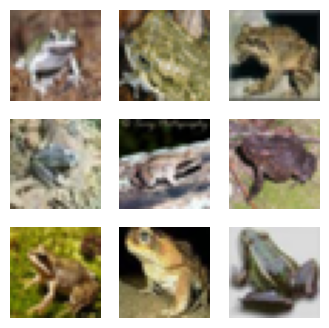

In [4]:
# #Test only grabbing images of one type

#Load the CIFAR10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Concatenate X_train and X_test for more data
X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train,y_test))
#Only use index 0, AKA Airplanes
index = np.where(y_train.reshape(-1) == 6)
X_train = X_train[index]
y_train = y_train[index]

#Testing to make sure it's just airplanes
fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)
cnt=0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[-9:][cnt,:,:])
        axs[i, j].axis('off')
        cnt+=1

image shape (32, 32, 3), min val -1.0, max val 1.0
Epoch 0
Time for epoch:  26.402348279953003
loss_d=0.36312, loss_g=1.32071
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

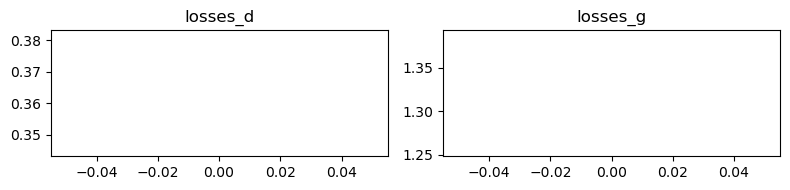

Epoch 1
Time for epoch:  23.60612654685974
Epoch 2
Time for epoch:  26.038914442062378
Epoch 3
Time for epoch:  26.118326663970947
Epoch 4
Time for epoch:  27.0931077003479
Epoch 5
Time for epoch:  26.512622356414795
loss_d=0.62141, loss_g=0.96070
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


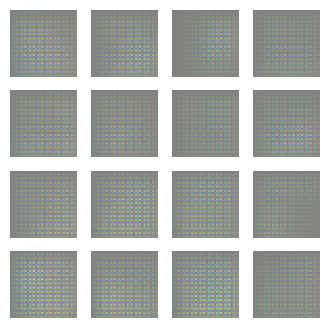

<Figure size 1600x1600 with 0 Axes>

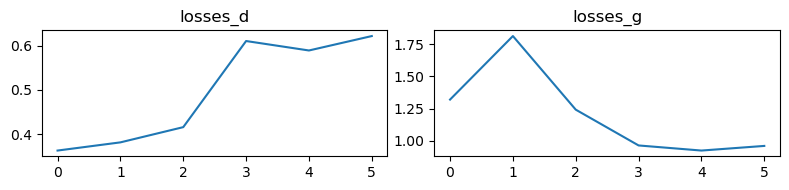

Epoch 6
Time for epoch:  26.759433031082153
Epoch 7
Time for epoch:  25.910412549972534
Epoch 8
Time for epoch:  24.59764337539673
Epoch 9
Time for epoch:  26.797621965408325
Epoch 10
Time for epoch:  26.730949640274048
loss_d=0.67465, loss_g=0.84322
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


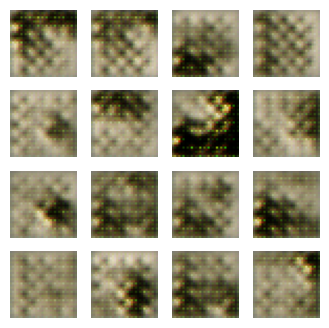

<Figure size 1600x1600 with 0 Axes>

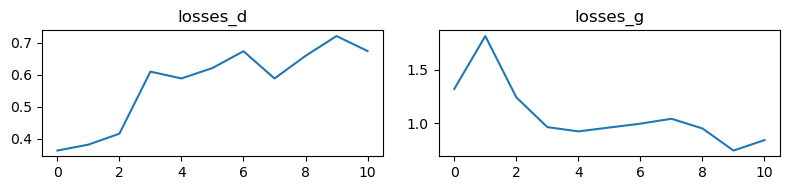

Epoch 11
Time for epoch:  26.685315370559692
Epoch 12
Time for epoch:  25.578487873077393
Epoch 13
Time for epoch:  29.761857509613037
Epoch 14
Time for epoch:  24.481531620025635
Epoch 15
Time for epoch:  24.211023330688477
loss_d=0.62240, loss_g=0.77628
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


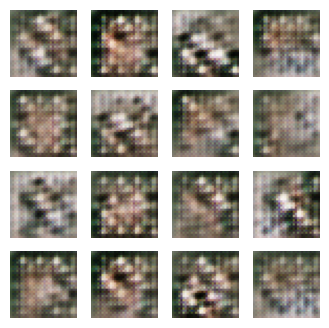

<Figure size 1600x1600 with 0 Axes>

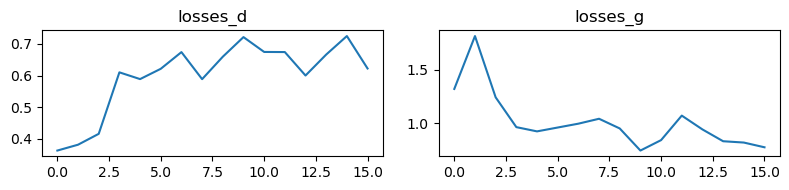

Epoch 16
Time for epoch:  26.51321506500244
Epoch 17
Time for epoch:  26.72508668899536
Epoch 18
Time for epoch:  25.413745164871216
Epoch 19
Time for epoch:  25.93053436279297
Epoch 20
Time for epoch:  25.908032417297363
loss_d=0.58960, loss_g=1.03105
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


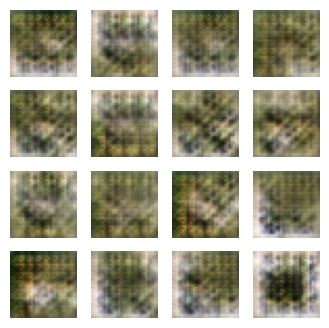

<Figure size 1600x1600 with 0 Axes>

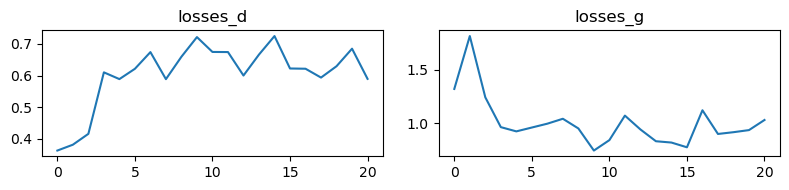

Epoch 21
Time for epoch:  24.434543132781982
Epoch 22
Time for epoch:  26.340632915496826
Epoch 23
Time for epoch:  25.000368356704712
Epoch 24
Time for epoch:  24.505810976028442
Epoch 25
Time for epoch:  25.960206031799316
loss_d=0.66349, loss_g=1.03131
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


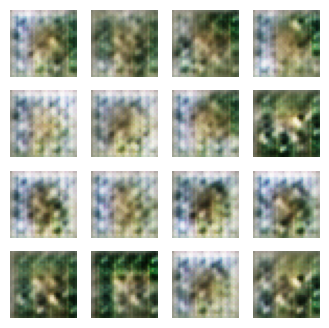

<Figure size 1600x1600 with 0 Axes>

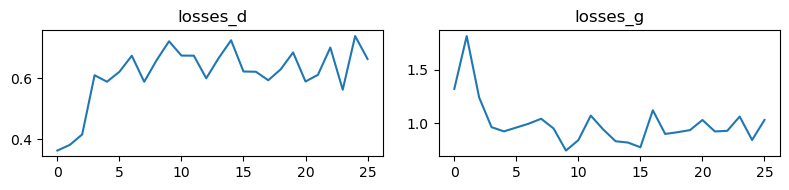

Epoch 26
Time for epoch:  24.50108504295349
Epoch 27
Time for epoch:  24.012205839157104
Epoch 28
Time for epoch:  24.007777214050293
Epoch 29
Time for epoch:  23.894707918167114
Epoch 30
Time for epoch:  24.055100917816162
loss_d=0.69706, loss_g=0.78334
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


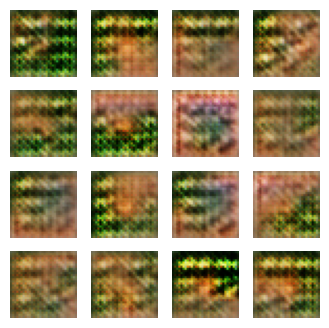

<Figure size 1600x1600 with 0 Axes>

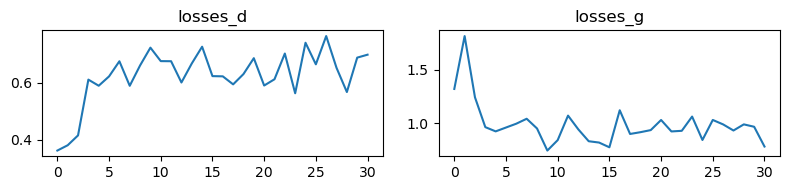

Epoch 31
Time for epoch:  24.254919052124023
Epoch 32
Time for epoch:  24.731786966323853
Epoch 33
Time for epoch:  22.68564248085022
Epoch 34
Time for epoch:  22.525541305541992
Epoch 35
Time for epoch:  22.549927711486816
loss_d=0.65256, loss_g=0.96808
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


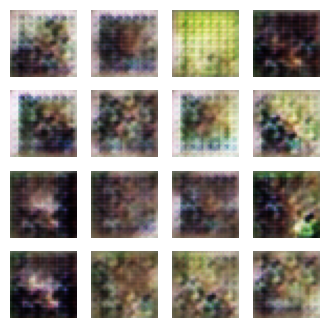

<Figure size 1600x1600 with 0 Axes>

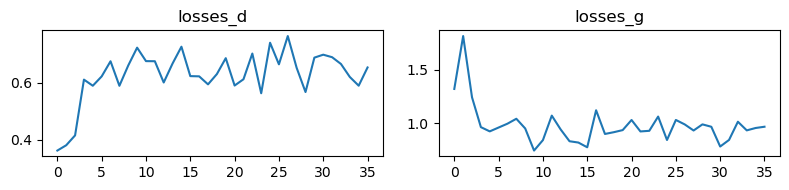

Epoch 36
Time for epoch:  22.682637214660645
Epoch 37
Time for epoch:  22.635931730270386
Epoch 38
Time for epoch:  22.68802809715271
Epoch 39
Time for epoch:  23.519084930419922
Epoch 40
Time for epoch:  25.286877155303955
loss_d=0.62723, loss_g=0.94419
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


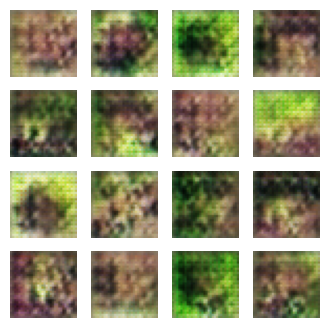

<Figure size 1600x1600 with 0 Axes>

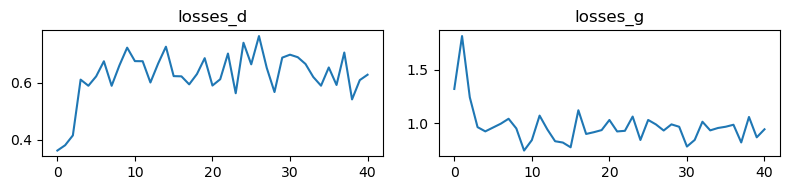

Epoch 41
Time for epoch:  24.06883454322815
Epoch 42
Time for epoch:  24.39647650718689
Epoch 43
Time for epoch:  24.775490283966064
Epoch 44
Time for epoch:  24.518078327178955
Epoch 45
Time for epoch:  25.454788208007812
loss_d=0.59546, loss_g=1.08489
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


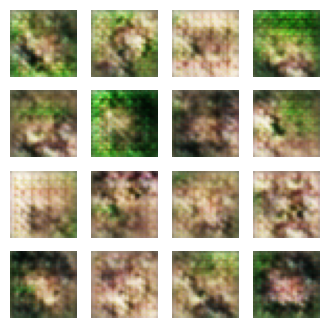

<Figure size 1600x1600 with 0 Axes>

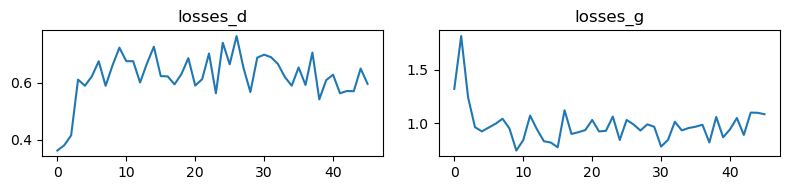

Epoch 46
Time for epoch:  26.43115210533142
Epoch 47
Time for epoch:  25.346211433410645
Epoch 48
Time for epoch:  24.193763732910156
Epoch 49
Time for epoch:  24.011346340179443
Epoch 50
Time for epoch:  23.734322547912598
loss_d=0.55556, loss_g=1.10952
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


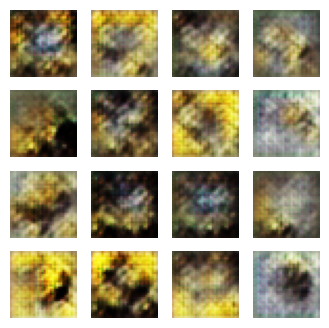

<Figure size 1600x1600 with 0 Axes>

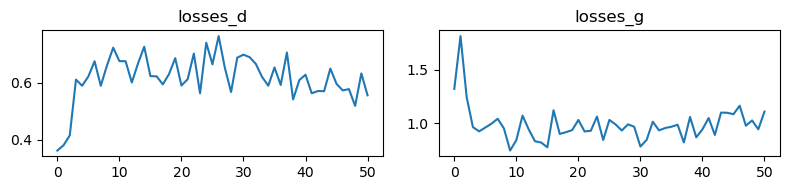

Epoch 51
Time for epoch:  24.008831024169922
Epoch 52
Time for epoch:  24.779349088668823
Epoch 53
Time for epoch:  23.908534288406372
Epoch 54
Time for epoch:  23.317785024642944
Epoch 55
Time for epoch:  23.585273504257202
loss_d=0.65135, loss_g=1.02080
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


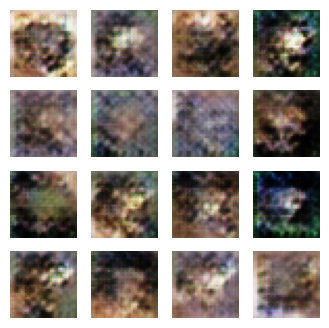

<Figure size 1600x1600 with 0 Axes>

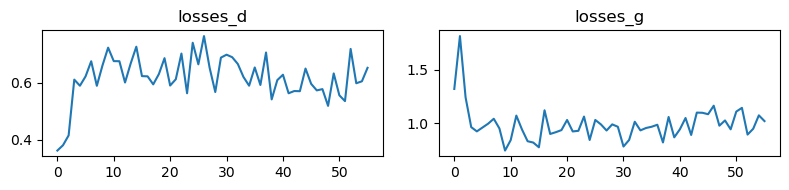

Epoch 56
Time for epoch:  23.882888317108154
Epoch 57
Time for epoch:  26.355263471603394
Epoch 58
Time for epoch:  24.747843980789185
Epoch 59
Time for epoch:  24.751054525375366
Epoch 60
Time for epoch:  24.768966674804688
loss_d=0.56227, loss_g=1.07514
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


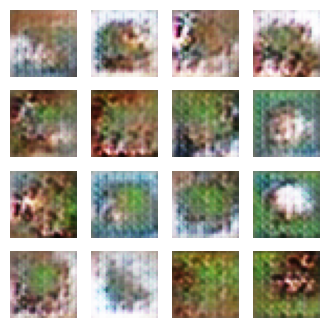

<Figure size 1600x1600 with 0 Axes>

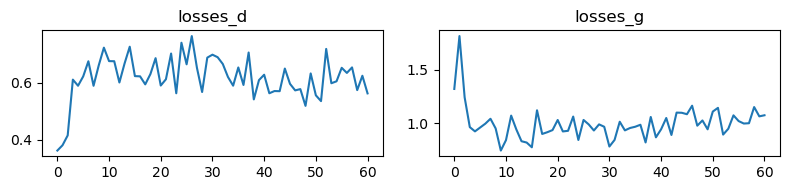

Epoch 61
Time for epoch:  24.814874410629272
Epoch 62
Time for epoch:  24.984594345092773
Epoch 63
Time for epoch:  24.93661618232727
Epoch 64
Time for epoch:  24.764869689941406
Epoch 65
Time for epoch:  24.89416265487671
loss_d=0.65943, loss_g=0.97011
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


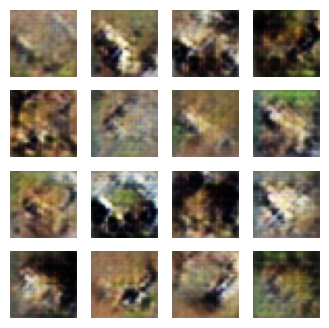

<Figure size 1600x1600 with 0 Axes>

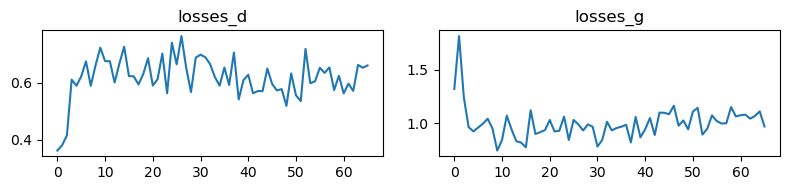

Epoch 66
Time for epoch:  25.325841426849365
Epoch 67
Time for epoch:  25.297178268432617
Epoch 68
Time for epoch:  25.566924810409546
Epoch 69
Time for epoch:  25.558736562728882
Epoch 70
Time for epoch:  25.079160928726196
loss_d=0.62284, loss_g=0.96257
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


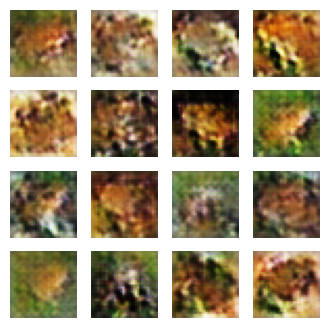

<Figure size 1600x1600 with 0 Axes>

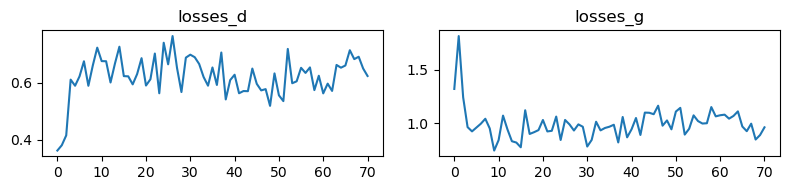

Epoch 71
Time for epoch:  25.284324169158936
Epoch 72
Time for epoch:  25.0472092628479
Epoch 73
Time for epoch:  25.20118522644043
Epoch 74
Time for epoch:  25.050724744796753
Epoch 75
Time for epoch:  25.380683660507202
loss_d=0.69808, loss_g=0.92165
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


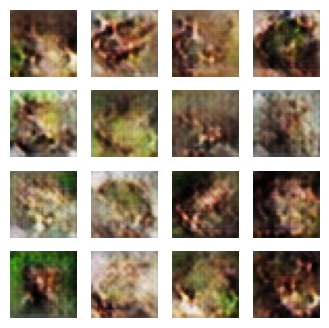

<Figure size 1600x1600 with 0 Axes>

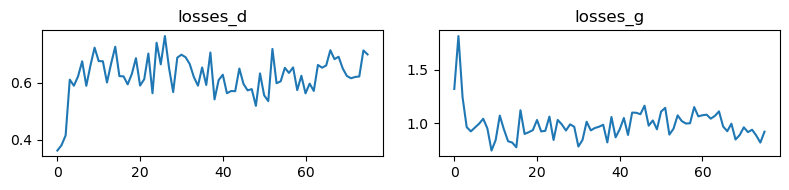

Epoch 76
Time for epoch:  25.200848817825317
Epoch 77
Time for epoch:  25.16713285446167
Epoch 78
Time for epoch:  25.248400688171387
Epoch 79
Time for epoch:  25.94163942337036
Epoch 80
Time for epoch:  25.336026668548584
loss_d=0.64234, loss_g=0.88064
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


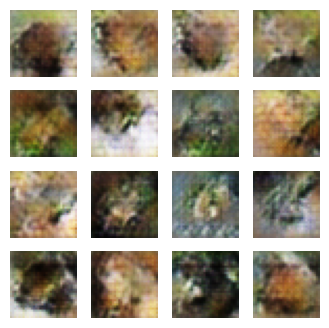

<Figure size 1600x1600 with 0 Axes>

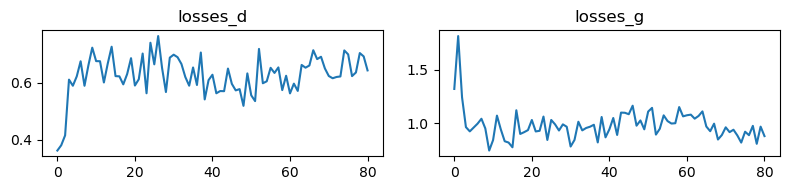

Epoch 81
Time for epoch:  24.172016620635986
Epoch 82
Time for epoch:  23.744638681411743
Epoch 83
Time for epoch:  24.77355146408081
Epoch 84
Time for epoch:  24.696053981781006
Epoch 85
Time for epoch:  26.070027112960815
loss_d=0.63117, loss_g=0.93006
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


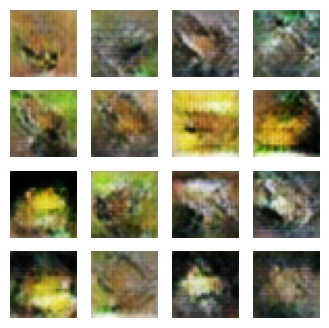

<Figure size 1600x1600 with 0 Axes>

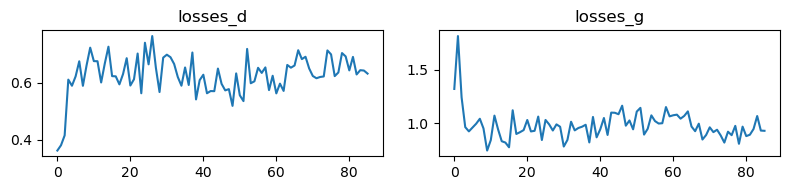

Epoch 86
Time for epoch:  26.581806659698486
Epoch 87
Time for epoch:  26.192500591278076
Epoch 88
Time for epoch:  26.687146186828613
Epoch 89
Time for epoch:  24.93034029006958
Epoch 90
Time for epoch:  24.14619493484497
loss_d=0.69490, loss_g=0.86690
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


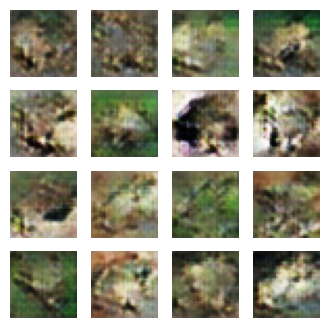

<Figure size 1600x1600 with 0 Axes>

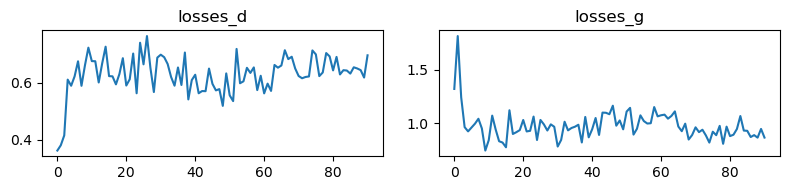

Epoch 91
Time for epoch:  22.82814311981201
Epoch 92
Time for epoch:  25.478328227996826
Epoch 93
Time for epoch:  23.93060564994812
Epoch 94
Time for epoch:  24.017081260681152
Epoch 95
Time for epoch:  22.769866704940796
loss_d=0.59094, loss_g=0.99948
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


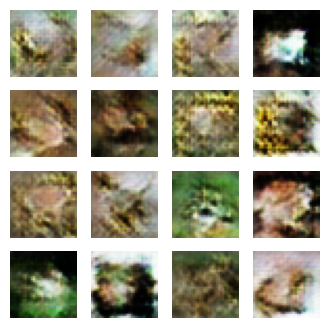

<Figure size 1600x1600 with 0 Axes>

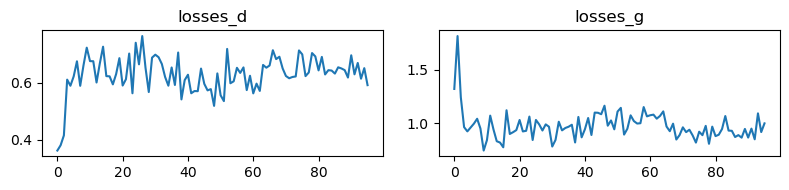

Epoch 96
Time for epoch:  22.82340383529663
Epoch 97
Time for epoch:  22.835055589675903
Epoch 98
Time for epoch:  22.86530351638794
Epoch 99
Time for epoch:  22.807552814483643
Epoch 100
Time for epoch:  22.84705352783203
loss_d=0.67499, loss_g=0.98934
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


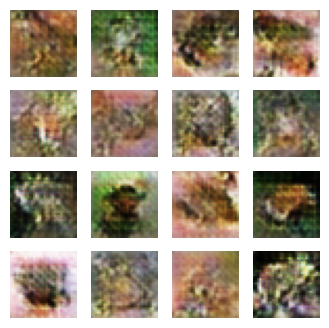

<Figure size 1600x1600 with 0 Axes>

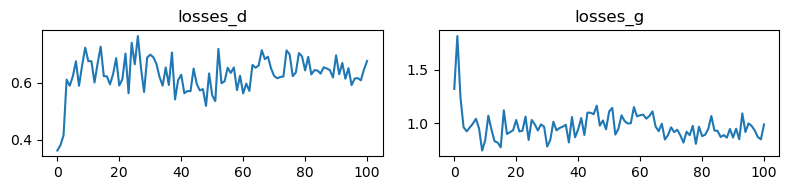

Epoch 101
Time for epoch:  22.706639766693115
Epoch 102
Time for epoch:  22.639144897460938
Epoch 103
Time for epoch:  22.82079291343689
Epoch 104
Time for epoch:  22.717252731323242
Epoch 105
Time for epoch:  22.61543107032776
loss_d=0.63708, loss_g=0.96994
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


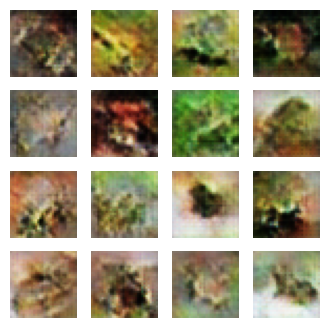

<Figure size 1600x1600 with 0 Axes>

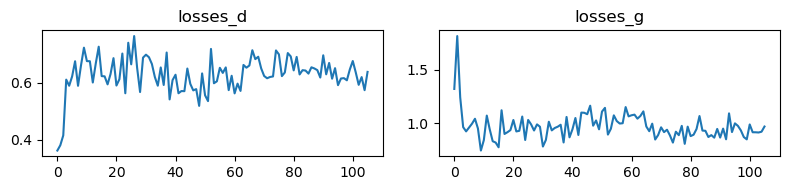

Epoch 106
Time for epoch:  22.676219701766968
Epoch 107
Time for epoch:  22.67717456817627
Epoch 108
Time for epoch:  22.661794900894165
Epoch 109
Time for epoch:  22.770328521728516
Epoch 110
Time for epoch:  22.67095446586609
loss_d=0.67669, loss_g=0.95686
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


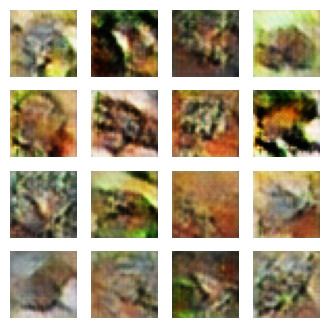

<Figure size 1600x1600 with 0 Axes>

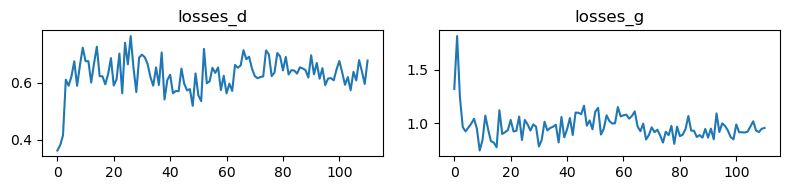

Epoch 111
Time for epoch:  22.846773147583008
Epoch 112
Time for epoch:  22.869181394577026
Epoch 113
Time for epoch:  22.91058611869812
Epoch 114
Time for epoch:  22.988383293151855
Epoch 115
Time for epoch:  22.782044649124146
loss_d=0.59913, loss_g=0.92510
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


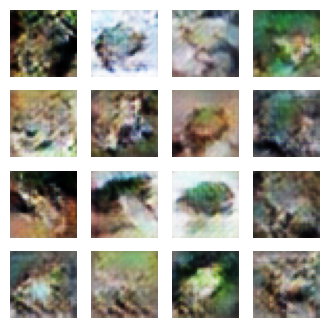

<Figure size 1600x1600 with 0 Axes>

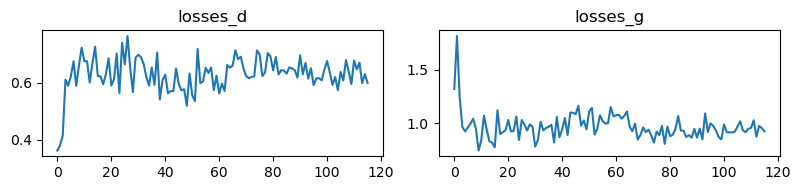

Epoch 116
Time for epoch:  22.690735340118408
Epoch 117
Time for epoch:  22.711671113967896
Epoch 118
Time for epoch:  22.917017459869385
Epoch 119
Time for epoch:  22.745518445968628
Epoch 120
Time for epoch:  22.74039888381958
loss_d=0.68716, loss_g=0.88293
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


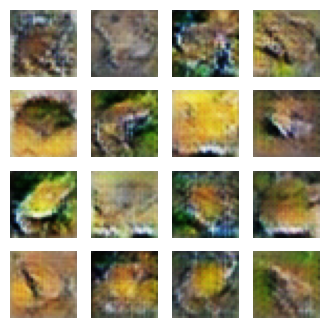

<Figure size 1600x1600 with 0 Axes>

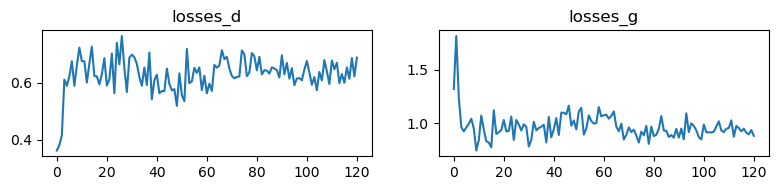

Epoch 121
Time for epoch:  23.71286129951477
Epoch 122
Time for epoch:  22.777570962905884
Epoch 123
Time for epoch:  26.280450344085693
Epoch 124
Time for epoch:  28.786730766296387
Epoch 125
Time for epoch:  28.554269790649414
loss_d=0.62487, loss_g=0.94283
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


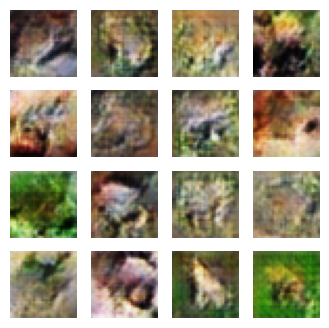

<Figure size 1600x1600 with 0 Axes>

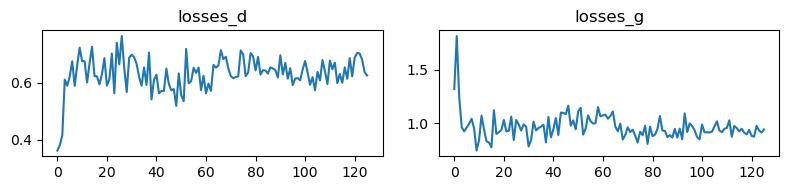

Epoch 126
Time for epoch:  28.357317447662354
Epoch 127
Time for epoch:  34.046950578689575
Epoch 128
Time for epoch:  34.48670506477356
Epoch 129
Time for epoch:  34.70665502548218
Epoch 130
Time for epoch:  30.589212656021118
loss_d=0.63748, loss_g=0.94635
2/2 [==============================] - 0s 8ms/step
	Plotting images and losses


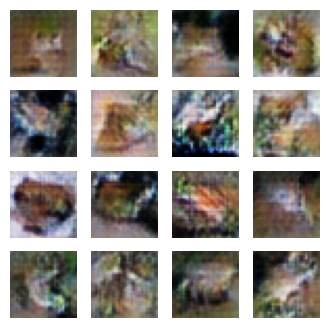

<Figure size 1600x1600 with 0 Axes>

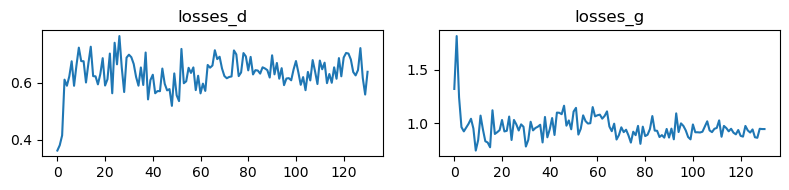

Epoch 131
Time for epoch:  39.05047631263733
Epoch 132
Time for epoch:  38.12521243095398
Epoch 133
Time for epoch:  40.42709159851074
Epoch 134
Time for epoch:  38.1328763961792
Epoch 135
Time for epoch:  38.40208601951599
loss_d=0.61643, loss_g=0.95589
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


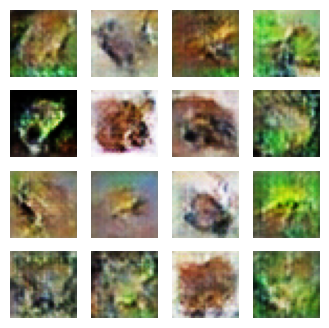

<Figure size 1600x1600 with 0 Axes>

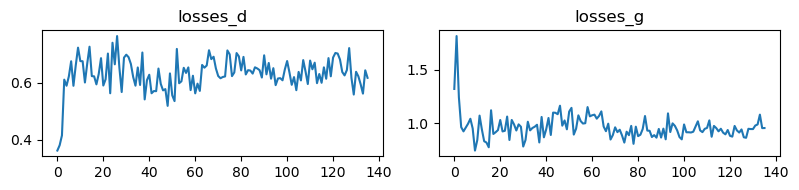

Epoch 136
Time for epoch:  37.62656617164612
Epoch 137
Time for epoch:  37.21189832687378
Epoch 138
Time for epoch:  37.684401512145996
Epoch 139
Time for epoch:  37.90950059890747
Epoch 140
Time for epoch:  37.63067650794983
loss_d=0.54607, loss_g=1.13193
2/2 [==============================] - 0s 7ms/step
	Plotting images and losses


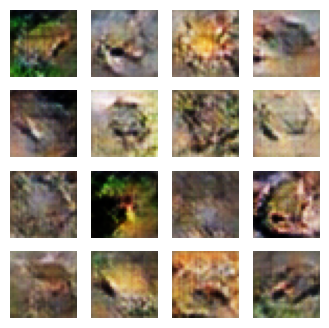

<Figure size 1600x1600 with 0 Axes>

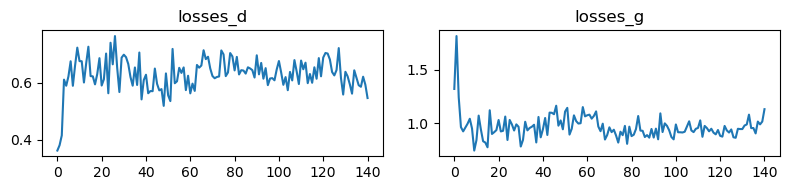

Epoch 141
Time for epoch:  38.46810793876648
Epoch 142
Time for epoch:  38.047950744628906
Epoch 143
Time for epoch:  37.66462445259094
Epoch 144
Time for epoch:  37.61283993721008
Epoch 145
Time for epoch:  38.06779456138611
loss_d=0.58434, loss_g=1.04243
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


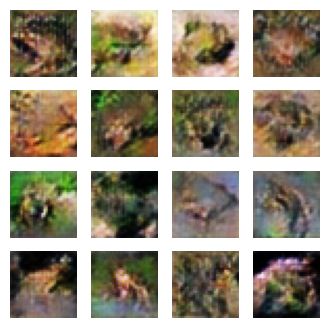

<Figure size 1600x1600 with 0 Axes>

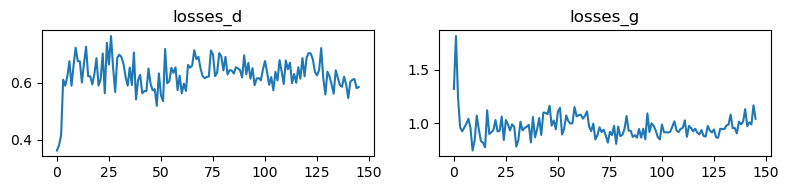

Epoch 146
Time for epoch:  37.35112190246582
Epoch 147
Time for epoch:  37.4061062335968
Epoch 148
Time for epoch:  37.39597225189209
Epoch 149
Time for epoch:  38.1082603931427


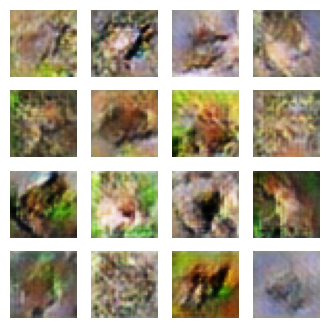

In [5]:
#Training Function
def train(z_dim=100, epochs=150,
          batch_size=16, epoch_per_checkpoint=5, n_checkpoint_images=36):

    #Load the CIFAR10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #Concatenate X_train and X_test for more data
    X_train = np.concatenate((X_train,X_test))
    y_train = np.concatenate((y_train,y_test))
    #Only grab frogs
    index = np.where(y_train.reshape(-1) == 6)
    X_train = X_train[index]
    y_train = y_train[index]
    #Convert data to floats, Scale data to -1, 1
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = X_train/127.5 - 1.0
    
    
    #Get image shapes and values for reference
    image_shape = X_train[0].shape
    print("image shape {}, min val {}, max val {}".format(image_shape, X_train[0].min(), X_train[0].max()))
    #Plot real images for reference
    plot_images(X_train[:n_checkpoint_images], "real_images.png")


    #Get labels for computing the losses
    labels_real = np.ones(shape=(batch_size, 1)) 
    labels_fake = np.zeros(shape=(batch_size, 1))
    #Smooth labels to prevent mode collapse
    labels_real = smooth_positive_labels(labels_real)
    labels_fake = smooth_negative_labels(labels_fake)

    losses_d, losses_g = [], []

    
    # training loop
    for e in range(epochs):
        start = time.time()
        print("Epoch {}".format(e))
        for i in range(len(X_train) // batch_size):

            # update Discriminator weights
            D.trainable = True

            # Get real samples, train discriminator on them
            real_images = X_train[i*batch_size: (i+1)*batch_size]
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 real_images[j] = noisy(real_images[j])
            loss_d_real = D.train_on_batch(x=real_images, y=labels_real)[0]

            # Make fake samples, train discriminator on them
            z = generate_latent_points(z_dim, batch_size)
            fake_images = G.predict_on_batch(z)
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 fake_images[j] = noisy(fake_images[j])
            loss_d_fake = D.train_on_batch(x=fake_images, y=labels_fake)[0]

            # Compute Discriminator's loss
            loss_d = 0.5 * (loss_d_real + loss_d_fake)

#             # Train the generator while the discriminator is static
#             D.trainable = False
#             loss_g1 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
#             # Update Generator again (train it twice as much as the Discriminator)
#             loss_g2 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
            
#             # Compute Generator's loss
#             loss_g = 0.5 * (loss_g1 + loss_g2)
            # Train the generator while the discriminator is static
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=labels_real)[0]


        #Keep track of losses for plotting
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        
        end = time.time()
        print("Time for epoch:  " + str(end-start))

        
        #Plot losses and generated images every X epochs
        if (e % epoch_per_checkpoint) == 0:
            print("loss_d={:.5f}, loss_g={:.5f}".format(loss_d, loss_g))
            
            # fix a z vector for training evaluation
            z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
            
            fake_images = G.predict(z_fixed)
            print("\tPlotting images and losses")
            plot_images(fake_images, "fake_images_frogs_e{}.png".format(e))
            plot_losses(losses_d, losses_g, "losses.png")
            
            #Show Images
            fake_images = (fake_images + 1) * 127.5
            fake_images = np.rint(fake_images)
            fake_images = fake_images.astype(int)

            fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
            cnt=0
            for k in range(4):
                for l in range(4):
                    axs[k, l].imshow(fake_images[cnt,:,:])
                    axs[k, l].axis('off')
                    cnt+=1

            #Save Model every 10 epochs
#             if (e % 10) == 0 and e != 0:
#                 print('Saving Models')
#                 D.save('./DiscriminatorModel')
#                 D_of_G.save('./CombinedModel')
            
            
train()

4/4 [==============================] - 0s 15ms/step


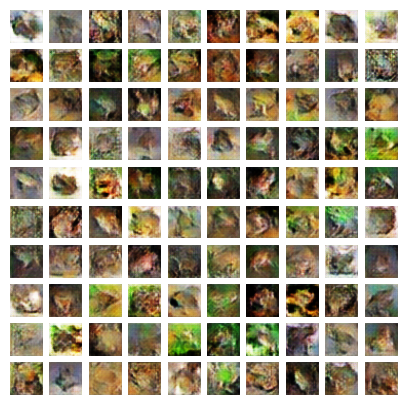

In [6]:
# #Print example images 
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1

4/4 [==============================] - 0s 11ms/step


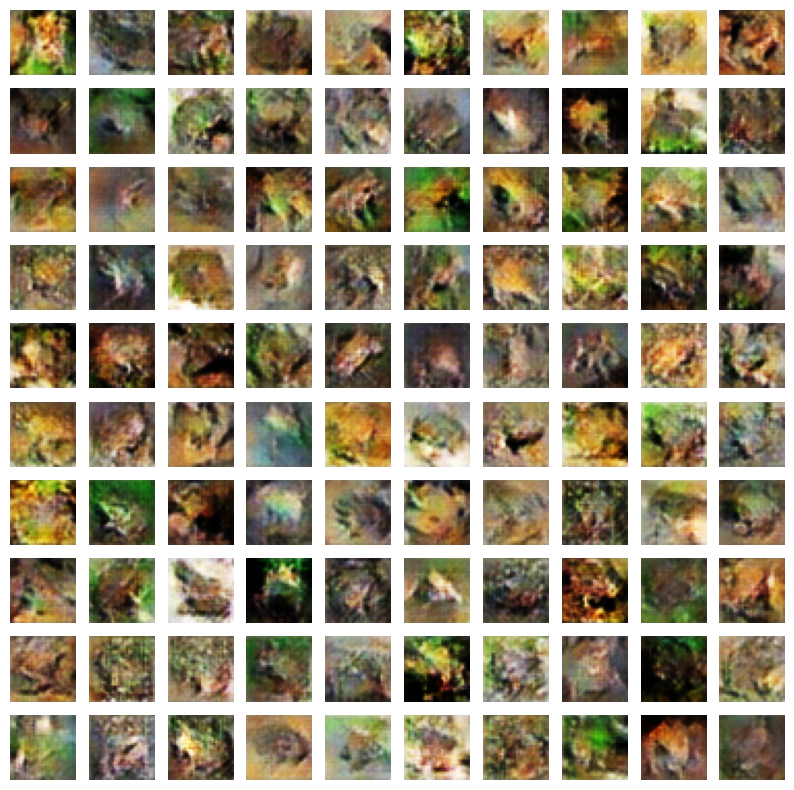

In [8]:
# #Print example images 
#Default Sets, 250 epochs
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(10,10),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1